In [20]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
from scipy.cluster import hierarchy
from scipy.cluster.hierarchy import dendrogram
from scipy.stats import zscore
import os
import sys
import sklearn
import numpy as np
from glob import glob
import random
from sklearn.cluster import AgglomerativeClustering
scriptpath = "../../src/"
sys.path.append(os.path.abspath(scriptpath))
import KmerGroups as kg
import PekaLib as peka

In [21]:
# FLAG-IP LIN data
PekaFiles = glob('../../data/LIN28_220626_results/PEKA/*5mer_distribution_UTR3*')
PekaScores = peka.GetPEKAScoresFromTsv(PekaFiles)
PekaRanks = peka.GetKmerRanksFromPEKAScore(PekaScores)
PekaRanks.index.name = 'motif'

# Motifs - WE ARE NOW ONLY INTERESTED IN THE K-MERS, NOT CLUSTERS
# Motifs were defined like this:
    # Get a union of significant k-mers in all samples, excluding S200A rep2
AllSamples = [v for v in PekaFiles if 'LIN28A-S200A_ESC_LIF-CHIR-FGF0220626_MM_2' not in v]
AllSamplesSignificant5mers = peka.GetSignificantKmersFileList(AllSamples)
kmerList = []
for v in AllSamplesSignificant5mers.values():
    kmerList.extend(v)
kmers = sorted(set(kmerList))

outpath = '../../results/20220906_ClusterKmers/'
srcOut = '../../results/SourceData/'
os.makedirs(outpath, exist_ok=True)

In [22]:
zScores = PekaScores.fillna(0).apply(zscore)

In [23]:
len(kmers)

93

In [24]:
PekaScores.head()

,LIN28A-S200A_ESC_LIF-CHIR-FGF0220626_MM_1_5mer_distribution_UTR3.tsv,LIN28A-WT_ESCiLIF0220626_MM_1_5mer_distribution_UTR3.tsv,LIN28A-WT_ESC_LIF-CHIR-FGF0220626_MM_2_5mer_distribution_UTR3.tsv,LIN28A-WT_ESC_LIF-CHIR-FGF0220626_MM_1_5mer_distribution_UTR3.tsv,LIN28A-WT_ESCiLIF-OLD0220626_MM_5mer_distribution_UTR3.tsv,LIN28A-WT_ESCiLIF0220626_MM_2_5mer_distribution_UTR3.tsv
motif,,,,,,
AAAAA,NaN,NaN,9.183656,8.024710,4.822031,NaN
AAAAC,NaN,NaN,0.738548,2.727032,NaN,NaN
AAAAG,NaN,NaN,3.975554,3.985754,-1.544493,0.019242
AAAAU,1.717574,13.340989,4.624674,2.957915,16.576716,15.076710
AAACA,NaN,NaN,NaN,NaN,NaN,NaN


In [25]:
kmers[:5]

['AAGGG', 'AAUAU', 'AAUUU', 'ACUUU', 'AGAUG']

In [26]:
def CombineDistanceMatrices(m1, m2, weight):
    """
    Combines two distances matrices for orthogonal variables.
    """
    # Standard scaling over columns
    scaler = sklearn.preprocessing.StandardScaler()
    m1Scaled = scaler.fit_transform(m1)
    m2Scaled = scaler.fit_transform(m2)
    # Apply min max scaling to move the matrices to be between 0 and 1
    MinMaxScaler = sklearn.preprocessing.MinMaxScaler()
    m1Normalized = MinMaxScaler.fit_transform(m1Scaled)
    m2Normalized = MinMaxScaler.fit_transform(m2Scaled)
    # Combine into one matrix using Pythagoras
    # Proportional contribution of m1 on the scale of 0 to 1
    m1Weighted = m1Normalized * weight
    m2Weighted = m2Normalized * 1
    combined_matrix = np.hypot(m1Weighted, m2Weighted)
    return combined_matrix, weight

In [27]:
# Compute pairwise euclidean distances on PEKA ranks
# Perform sorting first
PekaRanks = PekaRanks.loc[kmers]
euclideanDistancePekaRanks = sklearn.metrics.pairwise.euclidean_distances(PekaRanks)
print(euclideanDistancePekaRanks.max())
# Compute pairwise k-mer sequence distances
distanceMatrixMotifs = 1 - kg.GetKmerSimilarityMatrixNoOccurrence(kmers, minLen=1)
combined_matrix, weight = CombineDistanceMatrices(distanceMatrixMotifs, euclideanDistancePekaRanks, 1)

1496.2249162475541


In [28]:
pd.DataFrame(combined_matrix).head()

,0,1,2,3,4,5,6,7,8,9,...,83,84,85,86,87,88,89,90,91,92
0,0.000000,1.023624,1.049219,1.244743,1.008414,1.034213,0.811917,0.671704,0.475860,0.949872,...,1.111516,1.172315,1.161872,1.139505,1.042687,1.124225,1.112088,1.115075,1.109606,1.112177
1,1.021994,0.000000,0.787158,1.173911,0.967191,0.953468,1.051878,1.184829,1.058787,0.883241,...,0.791125,1.081708,1.068707,1.041813,1.012554,1.025459,0.937760,1.017182,1.015268,1.018265
2,1.088982,0.795135,0.000000,1.083375,1.008377,0.808812,1.120972,1.270384,1.109561,1.082473,...,0.767190,0.969890,0.952850,0.915206,0.869274,0.890078,0.833953,0.840843,0.833700,0.777993
3,1.414214,1.304380,1.145666,0.000000,1.406424,1.260518,1.414214,1.414214,1.414214,1.414214,...,1.155977,0.911839,0.927736,0.887040,1.157088,1.022845,1.131590,1.047799,1.108829,1.079868
4,0.993589,0.962167,0.980537,1.187291,0.000000,0.551935,0.796182,1.034687,0.954633,0.939252,...,0.984062,1.105485,1.090631,1.066339,0.969932,0.995136,1.038272,1.039425,0.968470,1.037279


In [29]:
sampleOrder = [
    'LIN28A-S200A_ESC_LIF-CHIR-FGF0220626_MM_1_5mer_distribution_UTR3.tsv',
    'LIN28A-WT_ESCiLIF-OLD0220626_MM_5mer_distribution_UTR3.tsv',
    'LIN28A-WT_ESCiLIF0220626_MM_1_5mer_distribution_UTR3.tsv',
    'LIN28A-WT_ESCiLIF0220626_MM_2_5mer_distribution_UTR3.tsv',
    'LIN28A-WT_ESC_LIF-CHIR-FGF0220626_MM_1_5mer_distribution_UTR3.tsv',
    'LIN28A-WT_ESC_LIF-CHIR-FGF0220626_MM_2_5mer_distribution_UTR3.tsv',
    ]

## K-mer cluster extraction

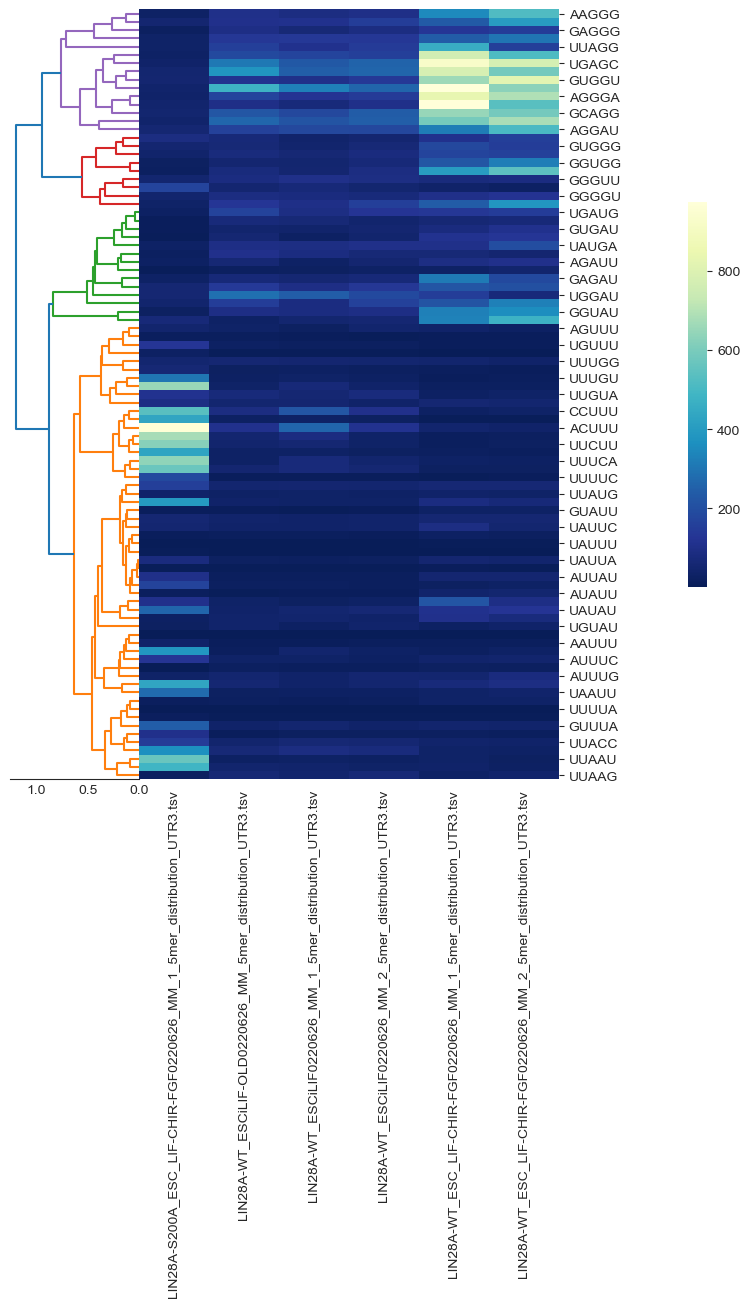

In [30]:
linkage = 'average'
distance='correlation'


Z = hierarchy.linkage(combined_matrix, method=linkage, metric=distance, optimal_ordering=True)

# Plot
sns.set_style("white")
fig, axs = plt.subplots(1, 2, gridspec_kw={'width_ratios': [.2, 1], 'wspace':0}, figsize=(10, 10))
dn = hierarchy.dendrogram(Z, labels=kmers, orientation='left', ax=axs[0], distance_sort='ascending')
groups_order = dn['ivl']
groups_order = groups_order[::-1]
ax = axs[0]
ax.tick_params(axis='both', bottom=False, right=False, labelright=False, labelbottom=True, pad=0.1)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
# ax.spines["bottom"].set_visible(False)
ax.spines["left"].set_visible(False)

sns.heatmap(PekaRanks.loc[groups_order, sampleOrder], cmap='YlGnBu_r', ax = axs[1], cbar_kws={"shrink": 0.5, "pad":0.2}, square=False)
axs[1].yaxis.tick_right()
axs[1].tick_params(axis='y', rotation=0)
axs[1].set_ylabel('')
# axs[1].set_yticklabels(['LIN28A-S200A FCL', 'LIN28A-S200WT 2iL 3', 'LIN28A-S200WT 2iL 1', 'LIN28A-S200WT 2iL 2', 'LIN28A-WT FCL 1', 'LIN28A-WT FCL 2'])

fig.savefig(f'{outpath}/clustermap_weight_{weight}_linkage_{linkage}_metric_{distance}.pdf', bbox_inches='tight')
fig.savefig(f'{outpath}/clustermap_weight_{weight}_linkage_{linkage}_metric_{distance}.png', bbox_inches='tight')

In [31]:
dfFlatClusters = pd.DataFrame()
dfFlatClusters = dfFlatClusters.assign(
    kmers = kmers,
    BroadClusters = scipy.cluster.hierarchy.fcluster(Z, 4, criterion='maxclust'),
)
dfFlatClusters.set_index('kmers', inplace=True)
dfFlatClusters = dfFlatClusters.loc[groups_order]

# Re-label clusters in the way that they follow each other from top to bottom
clUnordered = []
for c in dfFlatClusters.BroadClusters.values.tolist():
    if c not in clUnordered:
        clUnordered.append(c)
i=0
for v in clUnordered:
    dfFlatClusters.loc[dfFlatClusters.BroadClusters == v, 'FinalClusters'] = int(i)
    i += 1

In [32]:
dfFlatClusters

,BroadClusters,FinalClusters
kmers,,
AAGGG,4,0.0
AGGGG,4,0.0
GAGGG,4,0.0
GGGAA,4,0.0
UUAGG,4,0.0
...,...,...
UUACC,2,3.0
UUACU,2,3.0
UUAAU,2,3.0


In [33]:
# Save clustered dataframe in the order of the dendrogram - SourceData
dfS = PekaRanks.loc[groups_order, sampleOrder].copy()
# Clean up file names
dfS.columns = [v.split('_5mer_distribution_UTR3.tsv')[0] for v in dfS.columns]
# Annotate with cluster information
dfS['cluster'] = dfFlatClusters.FinalClusters
# Name clusters with motif group names
clDict = {
    0: 'WGG',
    1: 'WGG',
    2: 'UGAU',
    3: 'AUU',
}
dfS['cluster'] = dfS['cluster'].map(clDict)
dfS.to_csv(f'{srcOut}/Exd4-a_PekaHeatmap_ClusteredKmerRanks.csv', index=True)
del dfS

In [35]:
dfFlatClusters

,BroadClusters,FinalClusters
kmers,,
AAGGG,4,0.0
AGGGG,4,0.0
GAGGG,4,0.0
GGGAA,4,0.0
UUAGG,4,0.0
...,...,...
UUACC,2,3.0
UUACU,2,3.0
UUAAU,2,3.0


['AAGGG', 'AGGGG', 'GAGGG', 'GGGAA', 'UUAGG', 'AGUGA', 'UGAGC', 'CGUGG', 'GUGGU', 'GCGUG', 'AGGGA', 'GGAGG', 'GCAGG', 'GAUAG', 'AGGAU']


/home/klara/mambaforge/envs/JupyterAnalyses/lib/python3.7/site-packages/pandas/core/internals/blocks.py:937: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr_value = np.asarray(value)
/home/klara/mambaforge/envs/JupyterAnalyses/lib/python3.7/site-packages/seqlogo/core.py:626: RuntimeWarning: divide by zero encountered in log2
  return _init_pm(np.log2(ppm +  pseudocount) - np.log2(background), pm_type = 'pwm', alphabet_type = alphabet_type, alphabet = alphabet)


['UGGGG', 'GUGGG', 'UUGGG', 'GGUGG', 'UGGUG', 'GGGUU', 'GGUUU', 'GGGGU', 'GGUUG']


/home/klara/mambaforge/envs/JupyterAnalyses/lib/python3.7/site-packages/pandas/core/internals/blocks.py:937: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr_value = np.asarray(value)
/home/klara/mambaforge/envs/JupyterAnalyses/lib/python3.7/site-packages/seqlogo/core.py:626: RuntimeWarning: divide by zero encountered in log2
  return _init_pm(np.log2(ppm +  pseudocount) - np.log2(background), pm_type = 'pwm', alphabet_type = alphabet_type, alphabet = alphabet)


['UGAUG', 'AUGAU', 'GUGAU', 'UGAUA', 'UAUGA', 'GGAUU', 'AGAUU', 'UGAUU', 'GAGAU', 'AGAUG', 'UGGAU', 'GAUAC', 'GGUAU', 'AGUAU']


/home/klara/mambaforge/envs/JupyterAnalyses/lib/python3.7/site-packages/pandas/core/internals/blocks.py:937: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr_value = np.asarray(value)
/home/klara/mambaforge/envs/JupyterAnalyses/lib/python3.7/site-packages/seqlogo/core.py:626: RuntimeWarning: divide by zero encountered in log2
  return _init_pm(np.log2(ppm +  pseudocount) - np.log2(background), pm_type = 'pwm', alphabet_type = alphabet_type, alphabet = alphabet)


['AGUUU', 'GUUUU', 'UGUUU', 'UUUUU', 'UUUGG', 'UUUUG', 'UUUGU', 'UUGUU', 'UUGUA', 'AUGUU', 'CCUUU', 'CUUUU', 'ACUUU', 'UCUUU', 'UUCUU', 'UUUCU', 'UUUCA', 'UUUCC', 'UUUUC', 'GUUAU', 'UUAUG', 'UUAUC', 'GUAUU', 'UAUUG', 'UAUUC', 'AUUUA', 'UAUUU', 'UUUAU', 'UAUUA', 'UUAUU', 'AUUAU', 'UUAUA', 'AUAUU', 'AAUAU', 'UAUAU', 'GAUAU', 'UGUAU', 'AUUUU', 'AAUUU', 'CAUUU', 'AUUUC', 'GAUUU', 'AUUUG', 'GAAUU', 'UAAUU', 'UUUAG', 'UUUUA', 'UUUAA', 'GUUUA', 'UUUAC', 'UUACC', 'UUACU', 'UUAAU', 'UUAAA', 'UUAAG']


/home/klara/mambaforge/envs/JupyterAnalyses/lib/python3.7/site-packages/pandas/core/internals/blocks.py:937: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr_value = np.asarray(value)
/home/klara/mambaforge/envs/JupyterAnalyses/lib/python3.7/site-packages/seqlogo/core.py:626: RuntimeWarning: divide by zero encountered in log2
  return _init_pm(np.log2(ppm +  pseudocount) - np.log2(background), pm_type = 'pwm', alphabet_type = alphabet_type, alphabet = alphabet)


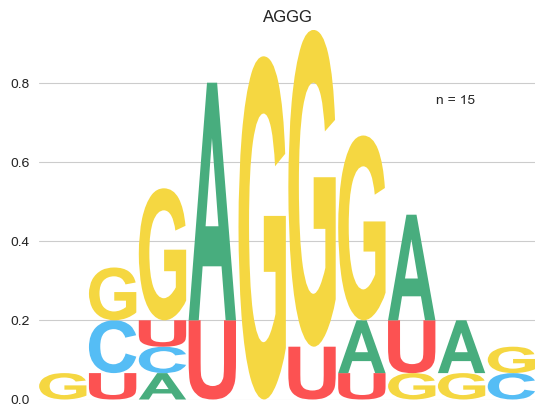

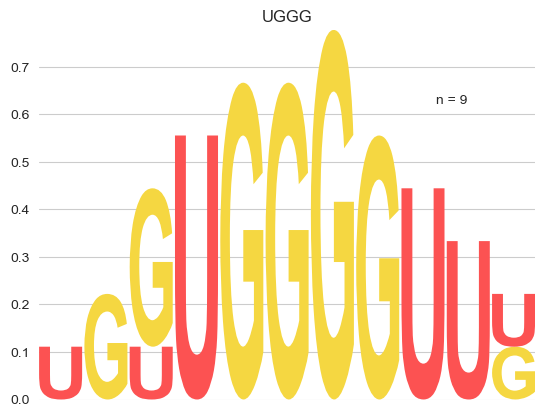

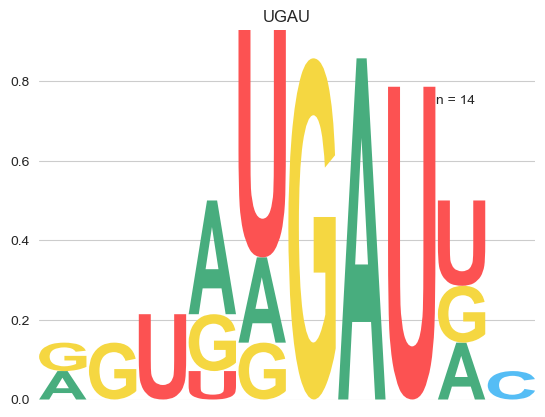

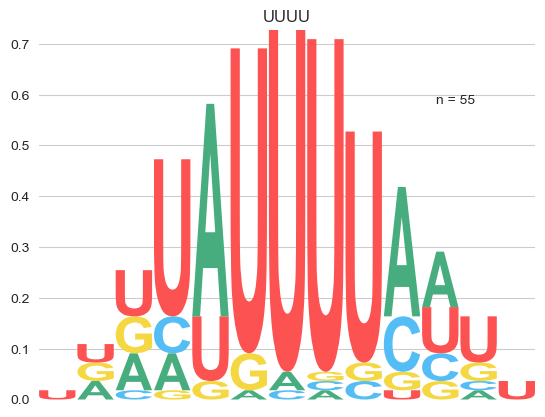

In [42]:
sns.set_style("whitegrid")
# Write alignments for motif groups to text file (source data)
with open(f'{srcOut}/Fig3-d-e-f_KmerAlignments_KmerLogoPlots.txt', 'w') as f:
    for g, df in dfFlatClusters.groupby('FinalClusters'):
        motifs = df.index.tolist()
        print(motifs)
        fig, ax = kg.PlotKmerLogoLogomaker(motifs, missm_s=-1)
        if len(motifs) > 1:
            consensus, alignment = kg.get_consensus_from_motifs(motifs)
            # Write a consensus line (append to file)
            f.write(f'Motif Group: {consensus}\n')
            # Write alignments
            for m in alignment:
                f.write(f'{m}\n')
        else:
            consensus = motifs[0]
        dfFlatClusters.loc[motifs, 'consensus'] = consensus
        ax.text(0.8, 0.8, f'n = {len(motifs)}', transform=ax.transAxes)
        ax.set_title(consensus)
        ax.grid(axis='x')
        sns.despine(left=True, bottom=True)
        for patch in ax.patches:
            patch.set_zorder(10)
        ax.tick_params(axis="x", labelbottom=False)
        fig.savefig(f'{outpath}/Logo_cluster_{g}_{consensus}_normalscale_{weight}.pdf', bbox_inches='tight')
        fig.savefig(f'{outpath}/Logo_cluster_{g}_{consensus}_normalscale_{weight}.png', bbox_inches='tight')

['AAGGG', 'AGGGG', 'GAGGG', 'GGGAA', 'UUAGG', 'AGUGA', 'UGAGC', 'CGUGG', 'GUGGU', 'GCGUG', 'AGGGA', 'GGAGG', 'GCAGG', 'GAUAG', 'AGGAU', 'UGGGG', 'GUGGG', 'UUGGG', 'GGUGG', 'UGGUG', 'GGGUU', 'GGUUU', 'GGGGU', 'GGUUG']


/home/klara/mambaforge/envs/JupyterAnalyses/lib/python3.7/site-packages/pandas/core/internals/blocks.py:937: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr_value = np.asarray(value)
/home/klara/mambaforge/envs/JupyterAnalyses/lib/python3.7/site-packages/seqlogo/core.py:626: RuntimeWarning: divide by zero encountered in log2
  return _init_pm(np.log2(ppm +  pseudocount) - np.log2(background), pm_type = 'pwm', alphabet_type = alphabet_type, alphabet = alphabet)


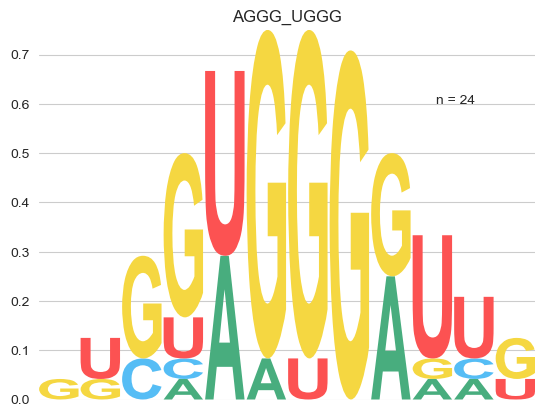

In [43]:
# Additionally plot logo for combined AGGG and UGGG group
df = dfFlatClusters.loc[dfFlatClusters.FinalClusters.isin([0, 1])]
motifs = df.index.tolist()
print(motifs)

alignment = kg.get_consensus_from_motifs(motifs)[1]

with open(f'{srcOut}/Fig3-d-e-f_KmerAlignments_KmerLogoPlots.txt', 'a') as f:
    f.write(f'Motif Group: WGG\n')
    for m in alignment:
        f.write(f'{m}\n')


fig, ax = kg.PlotKmerLogoLogomaker(motifs, missm_s=-1)
consensus = '_'.join(df.consensus.unique().tolist())
ax.text(0.8, 0.8, f'n = {len(motifs)}', transform=ax.transAxes)
ax.set_title(consensus)
sns.despine(left=True, bottom=True)
ax.grid(axis='x')
sns.despine(left=True, bottom=True)
for patch in ax.patches:
    patch.set_zorder(10)
ax.tick_params(axis="x", labelbottom=False)
fig.savefig(f'{outpath}/Logo_cluster_{consensus}_normalscale_{weight}.pdf', bbox_inches='tight')
fig.savefig(f'{outpath}/Logo_cluster_{consensus}_normalscale_{weight}.png', bbox_inches='tight')

## Plot z-scores across motif groups

In [ ]:
def assignCondition(x):
    if 'iLIF' in x:
        c='WT naive'
    elif 'WT_ESC_LIF-CHIR' in x:
        c='WT primed'
    elif 'S200A' in x:
        c='S200A primed'
    return c

dfPlot = dfFlatClusters.merge(PekaRanks, how='left', left_index=True, right_index=True).drop(columns=['FinalClusters', 'BroadClusters']).melt(
    id_vars=['consensus'], value_name='Rank', var_name='Sample'
)
dfPlot['Condition'] = dfPlot.Sample.apply(lambda x: assignCondition(x))
dfPlot

,consensus,Sample,Rank,Condition
0,AGGG,LIN28A-S200A_ESC_LIF-CHIR-FGF0220626_MM_1_5mer...,30.0,S200A primed
1,AGGG,LIN28A-S200A_ESC_LIF-CHIR-FGF0220626_MM_1_5mer...,51.0,S200A primed
2,AGGG,LIN28A-S200A_ESC_LIF-CHIR-FGF0220626_MM_1_5mer...,17.0,S200A primed
3,AGGG,LIN28A-S200A_ESC_LIF-CHIR-FGF0220626_MM_1_5mer...,35.0,S200A primed
4,AGGG,LIN28A-S200A_ESC_LIF-CHIR-FGF0220626_MM_1_5mer...,32.0,S200A primed
...,...,...,...,...
553,UUUU,LIN28A-WT_ESCiLIF0220626_MM_2_5mer_distributio...,58.0,WT naive
554,UUUU,LIN28A-WT_ESCiLIF0220626_MM_2_5mer_distributio...,75.0,WT naive
555,UUUU,LIN28A-WT_ESCiLIF0220626_MM_2_5mer_distributio...,27.0,WT naive
556,UUUU,LIN28A-WT_ESCiLIF0220626_MM_2_5mer_distributio...,35.0,WT naive


In [ ]:
dfPlot = dfFlatClusters.merge(zScores, how='left', left_index=True, right_index=True).drop(columns=['FinalClusters', 'BroadClusters']).melt(
    id_vars=['consensus'], value_name='Z-score', var_name='Sample'
)
dfPlot['Condition'] = dfPlot.Sample.apply(lambda x: assignCondition(x))
dfPlot.loc[dfPlot.consensus.isin(['AGGG', 'UGGG']), 'consensus'] = 'AGGG-UGGG'
dfPlot

,consensus,Sample,Z-score,Condition
0,AGGG-UGGG,LIN28A-S200A_ESC_LIF-CHIR-FGF0220626_MM_1_5mer...,2.108025,S200A primed
1,AGGG-UGGG,LIN28A-S200A_ESC_LIF-CHIR-FGF0220626_MM_1_5mer...,1.759175,S200A primed
2,AGGG-UGGG,LIN28A-S200A_ESC_LIF-CHIR-FGF0220626_MM_1_5mer...,2.687259,S200A primed
3,AGGG-UGGG,LIN28A-S200A_ESC_LIF-CHIR-FGF0220626_MM_1_5mer...,2.026965,S200A primed
4,AGGG-UGGG,LIN28A-S200A_ESC_LIF-CHIR-FGF0220626_MM_1_5mer...,2.045762,S200A primed
...,...,...,...,...
553,UUUU,LIN28A-WT_ESCiLIF0220626_MM_2_5mer_distributio...,1.345288,WT naive
554,UUUU,LIN28A-WT_ESCiLIF0220626_MM_2_5mer_distributio...,1.079317,WT naive
555,UUUU,LIN28A-WT_ESCiLIF0220626_MM_2_5mer_distributio...,2.265482,WT naive
556,UUUU,LIN28A-WT_ESCiLIF0220626_MM_2_5mer_distributio...,2.002452,WT naive


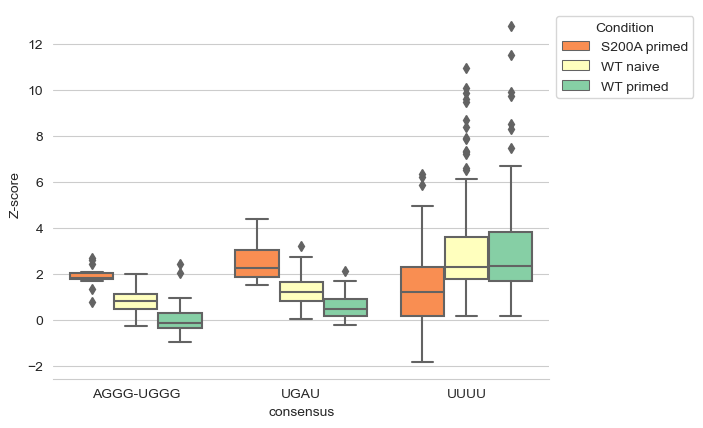

In [ ]:
sns.set_style('whitegrid')
ax = sns.boxplot(data=dfPlot, x='consensus', y='Z-score', hue='Condition', hue_order=sorted(dfPlot.Condition.unique()), palette="Spectral", saturation=1)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
sns.despine(left=True)
fig = ax.get_figure()
fig.savefig(f"{outpath}zScorePeka.pdf", bbox_inches='tight')

In [ ]:
dfPlot

,consensus,Sample,Z-score,Condition
0,AGGG-UGGG,LIN28A-S200A_ESC_LIF-CHIR-FGF0220626_MM_1_5mer...,2.108025,S200A primed
1,AGGG-UGGG,LIN28A-S200A_ESC_LIF-CHIR-FGF0220626_MM_1_5mer...,1.759175,S200A primed
2,AGGG-UGGG,LIN28A-S200A_ESC_LIF-CHIR-FGF0220626_MM_1_5mer...,2.687259,S200A primed
3,AGGG-UGGG,LIN28A-S200A_ESC_LIF-CHIR-FGF0220626_MM_1_5mer...,2.026965,S200A primed
4,AGGG-UGGG,LIN28A-S200A_ESC_LIF-CHIR-FGF0220626_MM_1_5mer...,2.045762,S200A primed
...,...,...,...,...
553,UUUU,LIN28A-WT_ESCiLIF0220626_MM_2_5mer_distributio...,1.345288,WT naive
554,UUUU,LIN28A-WT_ESCiLIF0220626_MM_2_5mer_distributio...,1.079317,WT naive
555,UUUU,LIN28A-WT_ESCiLIF0220626_MM_2_5mer_distributio...,2.265482,WT naive
556,UUUU,LIN28A-WT_ESCiLIF0220626_MM_2_5mer_distributio...,2.002452,WT naive


In [ ]:
dfFlatClusters.to_csv(f'{outpath}/FlatKmerClusters_Normalscale.tsv', sep='\t')

In [ ]:
with open(f'{outpath}/CLUSTER_motifGroupsFromAllKmers.txt', 'w') as f:
    for i, df in dfFlatClusters.groupby('FinalClusters'):
        clName = df.consensus.unique().tolist()[0]
        group = df.index.values.tolist()
        f.writelines(f'{clName}_Cluster_{i} ' + ','.join(group) + '\n')

with open(f'{outpath}/motifGroupsFromAllKmers.txt', 'w') as f:
    for i, df in dfFlatClusters.groupby('FinalClusters'):
        group = df.index.values.tolist()
        f.writelines(','.join(group) + '\n')